Found 7697 images belonging to 355 classes.
Found 3560 images belonging to 355 classes.
Epoch 1/750
240/240 [==============================] - 111s 447ms/step - loss: 5.8710 - accuracy: 0.0081 - val_loss: 5.8580 - val_accuracy: 0.0084
Epoch 2/750
240/240 [==============================] - 107s 446ms/step - loss: 5.8602 - accuracy: 0.0070 - val_loss: 5.8496 - val_accuracy: 0.0084
Epoch 3/750
240/240 [==============================] - 107s 447ms/step - loss: 5.8539 - accuracy: 0.0078 - val_loss: 5.8479 - val_accuracy: 0.0084
Epoch 4/750
240/240 [==============================] - 107s 447ms/step - loss: 5.8504 - accuracy: 0.0093 - val_loss: 5.8436 - val_accuracy: 0.0084
Epoch 5/750
240/240 [==============================] - 108s 448ms/step - loss: 5.8482 - accuracy: 0.0094 - val_loss: 5.8448 - val_accuracy: 0.0084
Epoch 6/750
240/240 [==============================] - 107s 446ms/step - loss: 5.8466 - accuracy: 0.0086 - val_loss: 5.8428 - val_accuracy: 0.0084
Epoch 7/750
240/240 [=========

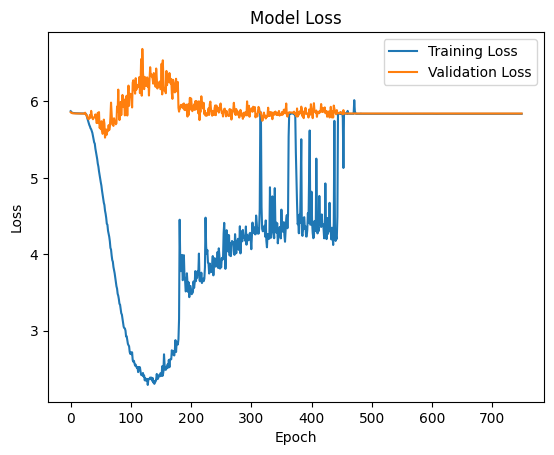

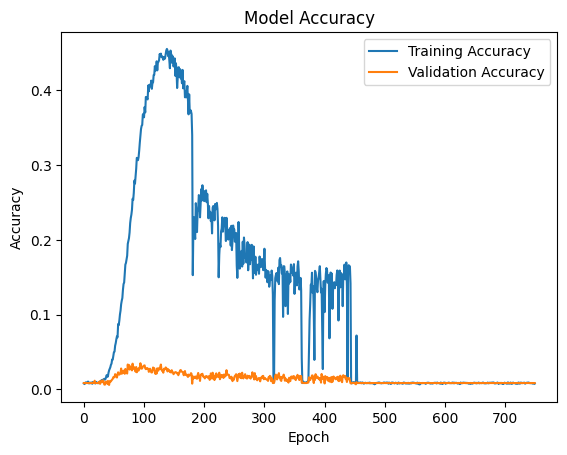

112/112 [==============================] - 14s 122ms/step
Accuracy (%): 0.8426966292134831
Average Precision (%): 0.0023737933217281215
Average Recall (%): 0.28169014084507044
Average F1 Score (%): 0.0047079132174663585


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from skimage.transform import resize
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
# Define data directories
train_data_dir = r"C:\Users\79894\Downloads\archive2_converted_train"
test_data_dir = r"C:\Users\79894\Downloads\archive2_converted_test"

# Define data generators with preprocessing_function (fixed image size)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
   preprocessing_function=lambda img: crop_dog(img, [10, 10, 100, 100])  # Pass the bounding box here
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # Adjusted to match the model input shape
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Adjusted to match the model input shape
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Function to crop dog from image using bounding box
def crop_dog(img, bbox, target_size=(224, 224)):
    x_min, y_min, width, height = bbox
    cropped_img = img[y_min:y_min+height, x_min:x_min+width]
    resized_img = resize(cropped_img, target_size, anti_aliasing=True)
    return resized_img
    
# Define the AlexNet model architecture
num_classes = 355  # Adjust based on the number of classes in your dataset

model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Adjust output neurons based on your classification task
])

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=750,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Extract results from the final epoch
final_epoch_results = {
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1]
}

# Print the final epoch results
print("Final Epoch Results:")
print(final_epoch_results)
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on test data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

# Calculate metrics
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

precision = []
recall = []
f1_score = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision_i = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall_i = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

    # Calculate F1 score
    if precision_i + recall_i != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0

    f1_score.append(f1_score_i)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Convert metrics to percentage format
accuracy_percentage = accuracy * 100
avg_precision_percentage = avg_precision * 100
avg_recall_percentage = avg_recall * 100
avg_f1_score_percentage = avg_f1_score * 100

# Print the metrics in percentage format
print("Accuracy (%):", accuracy_percentage)
print("Average Precision (%):", avg_precision_percentage)
print("Average Recall (%):", avg_recall_percentage)
print("Average F1 Score (%):", avg_f1_score_percentage)


In [2]:
pip install scikit-image

   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.5 MB 3.2 MB/s eta 0:00:08
   ---------------------------------------- 0.3/24.5 MB 3.2 MB/s eta 0:00:08
    --------------------------------------- 0.5/24.5 MB 3.7 MB/s eta 0:00:07
   - -------------------------------------- 1.0/24.5 MB 6.3 MB/s eta 0:00:04
   - -------------------------------------- 1.1/24.5 MB 6.3 MB/s eta 0:00:04
   - -------------------------------------- 1.1/24.5 MB 6.3 MB/s eta 0:00:04
   --- ------------------------------------ 2.4/24.5 MB 8.5 MB/s eta 0:00:03
   ----- ---------------------------------- 3.3/24.5 MB 9.4 MB/s eta 0:00:03
   ------ --------------------------------- 4.1/24.5 MB 10.3 MB/s eta 0:00:02
   ------- -------------------------------- 4.6/24.5 MB 11.2 MB/s eta 0:00:02
   -------- ------------------------------- 5.5/24.5 MB 12.1 MB/s eta 0:00:02
   -------- ------------------------------- 5.5/24.5 MB 12.1 MB/s eta 0:00:02
  